

<p align="center"><strong style="font-size:18px;">MASTER DE FINANZAS Y DIRECCIÓN FINANCIERA</strong></p>
<p align="center" style="font-size:18px;">Gestión Financiera</p>
</p>
<p align="center" style="font-size:18px;">Autor: Karen Fajardo</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import seaborn as sns
import cvxpy as cp

sns.set_style("whitegrid")

In [2]:
#Tomamos referencia para mejorar y establecer las metricas a mejorar de nuestra cartera 
# S&P 500 (^GSPC)
# IBEX 35 - (^IBEX)

# Rangos de Fechas
end_date = '2025-03-22'
start_date = '2020-03-22'

indices= ["^GSPC", "^IBEX"]

# Downloading data
indices_prices = yf.download(
    indices,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    multi_level_index=True,
)['Adj Close']



[*********************100%***********************]  2 of 2 completed


<Axes: >

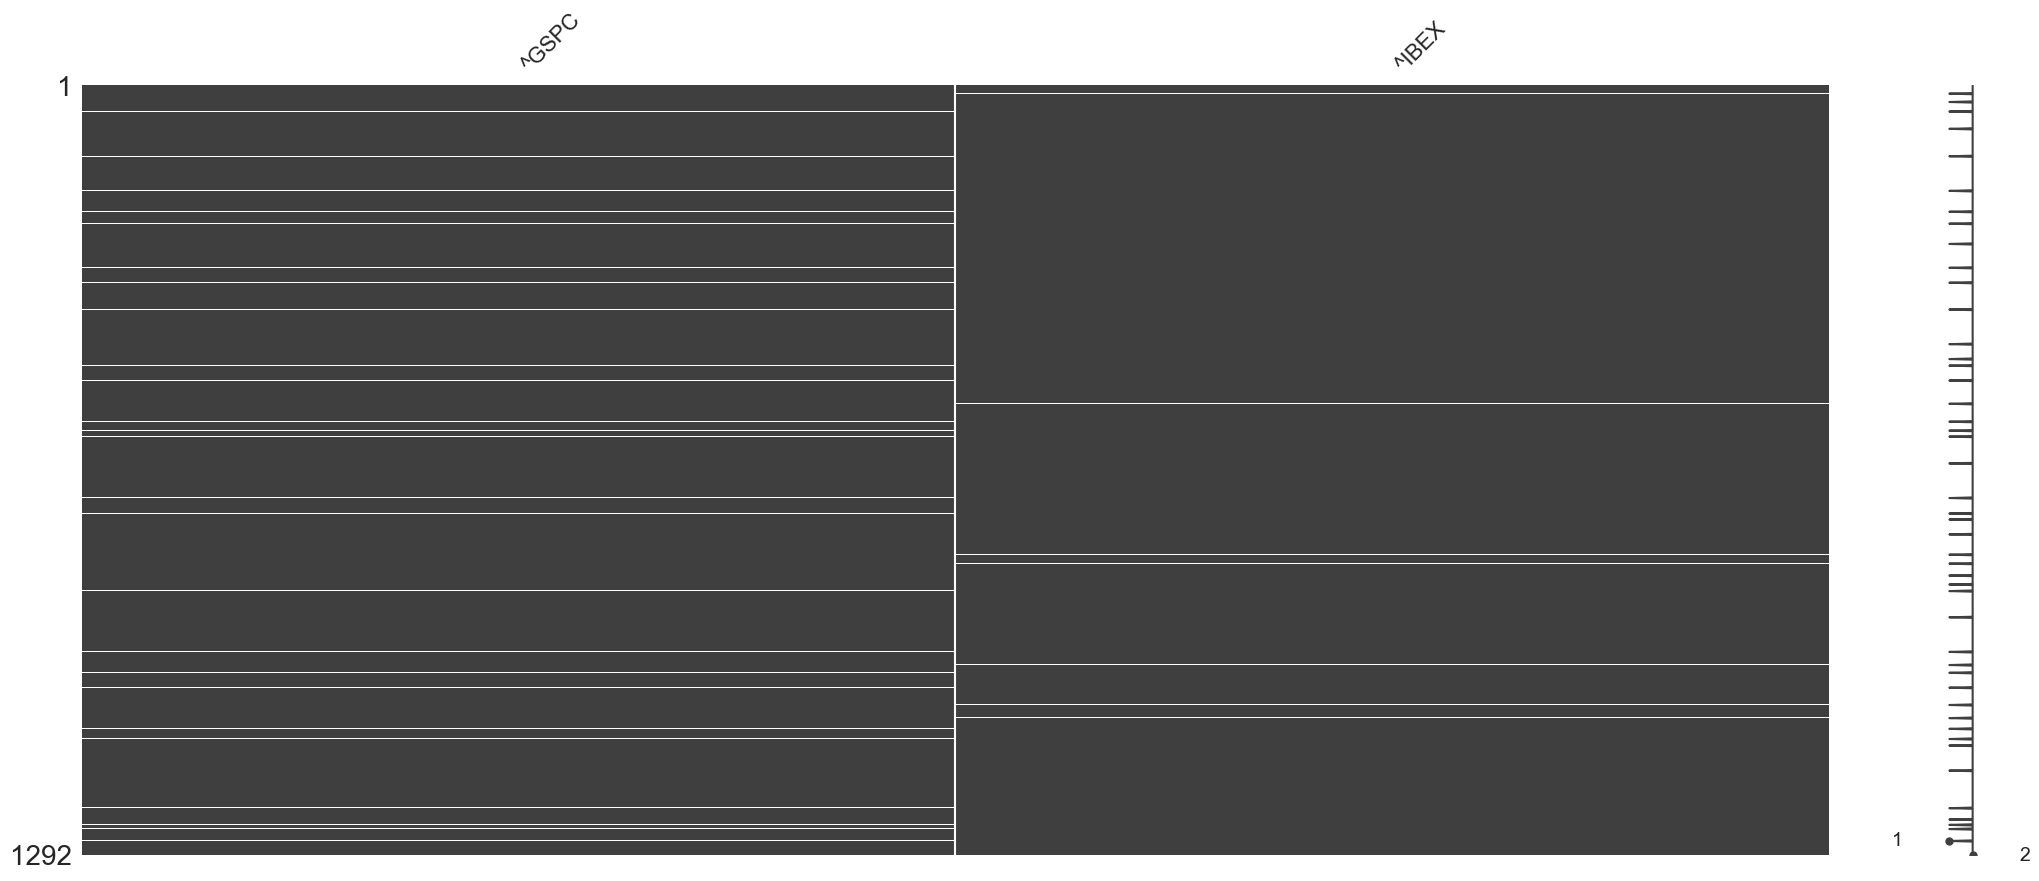

In [3]:
import missingno as msno

msno.matrix(indices_prices)


<Axes: >

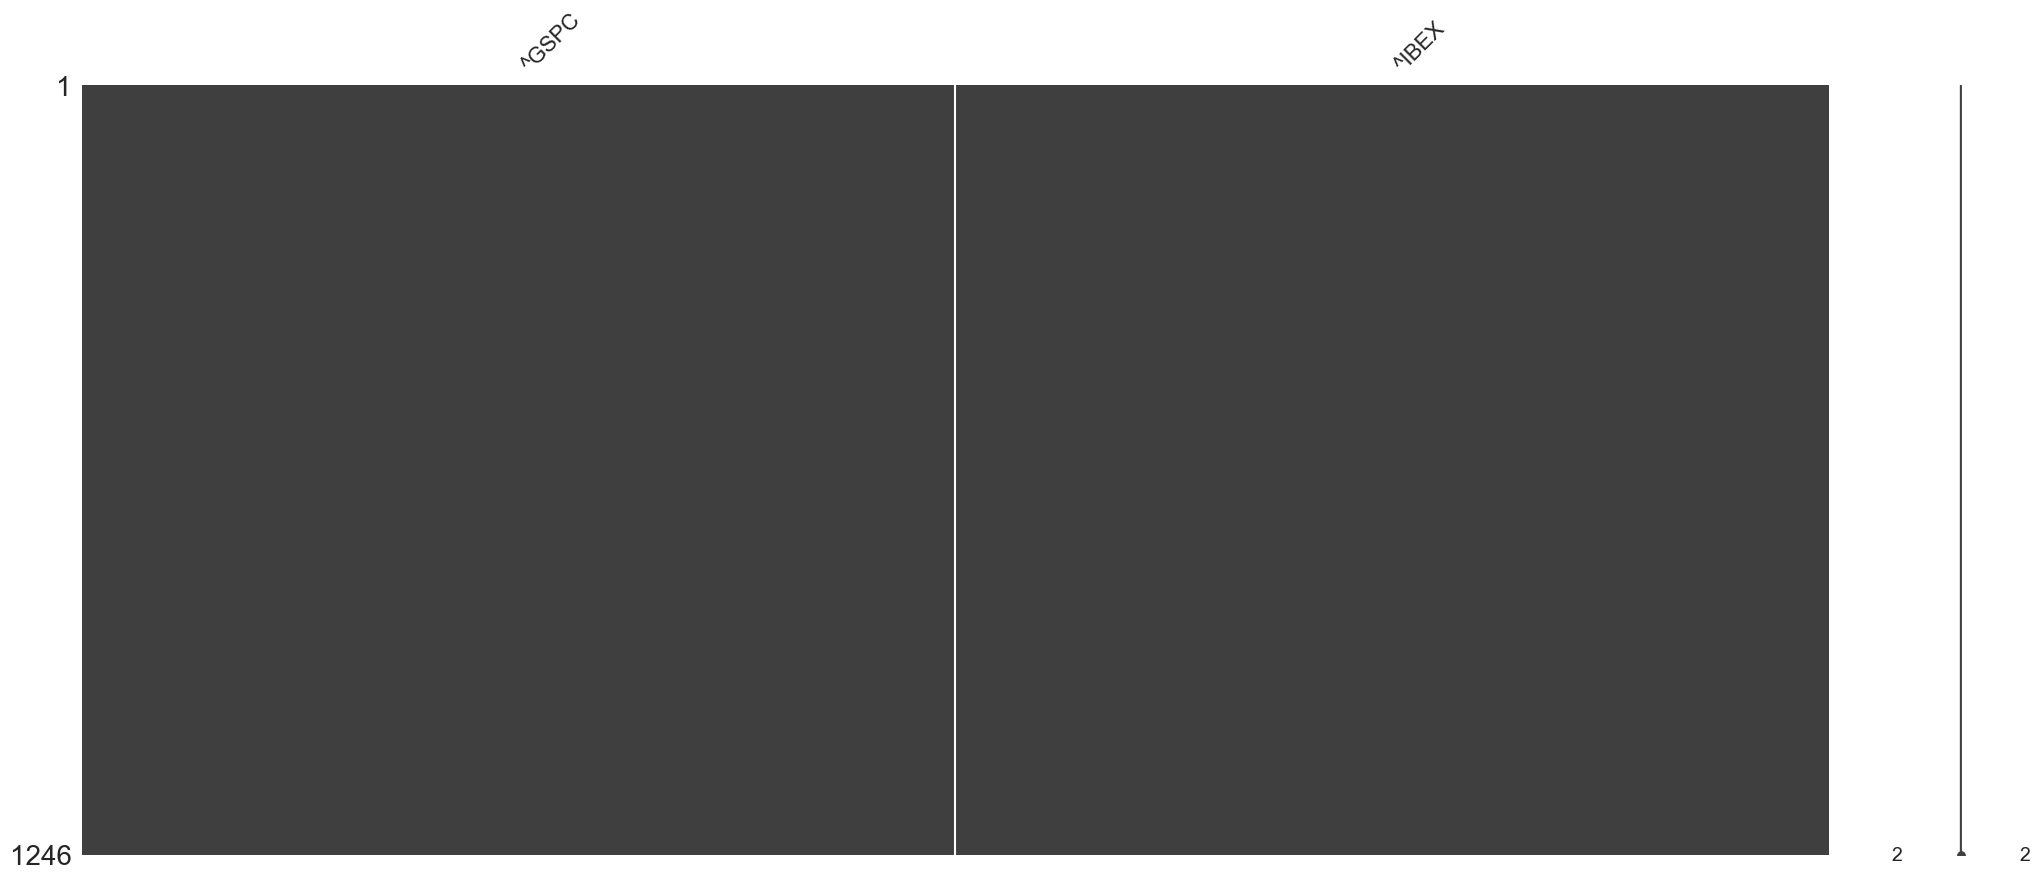

In [4]:
indices_pr = indices_prices.dropna(axis=0,how='any')

msno.matrix(indices_pr)

In [5]:
indices_pr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1246 entries, 2020-03-23 to 2025-03-21
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   1246 non-null   float64
 1   ^IBEX   1246 non-null   float64
dtypes: float64(2)
memory usage: 29.2 KB


<Axes: xlabel='Date'>

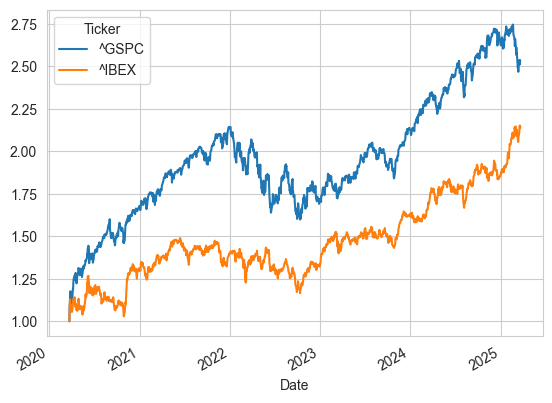

In [6]:
indices_mean_day = indices_pr/indices_pr.iloc[0, :]

indices_mean_day.plot()

In [7]:
retornos = np.log(indices_mean_day).diff().dropna()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

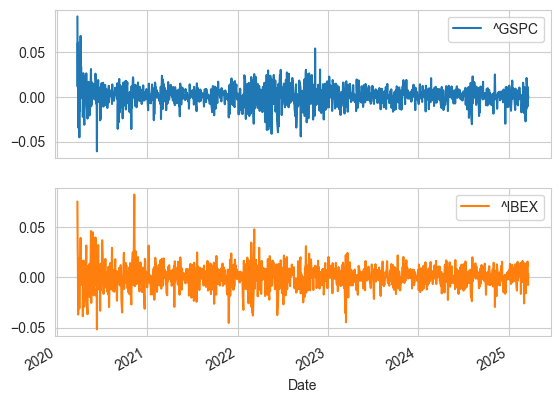

In [8]:
retornos.plot(subplots= True)

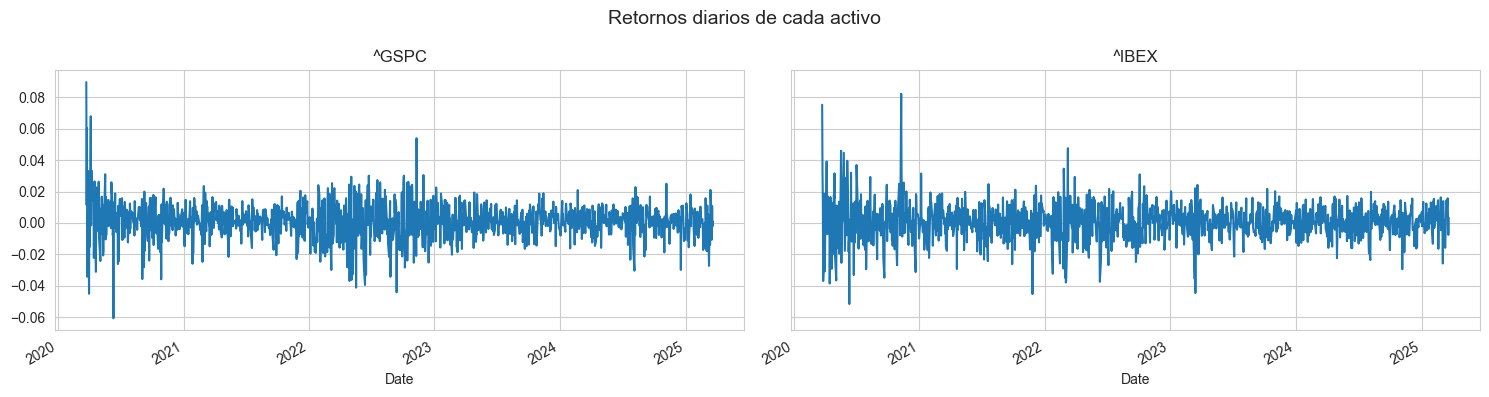

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=retornos.shape[1], figsize=(15, 4), sharey=True)

for i, col in enumerate(retornos.columns):
    retornos[col].plot(ax=axes[i], title=col)

fig.suptitle("Retornos diarios de cada activo", fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
df_skew = retornos.skew()

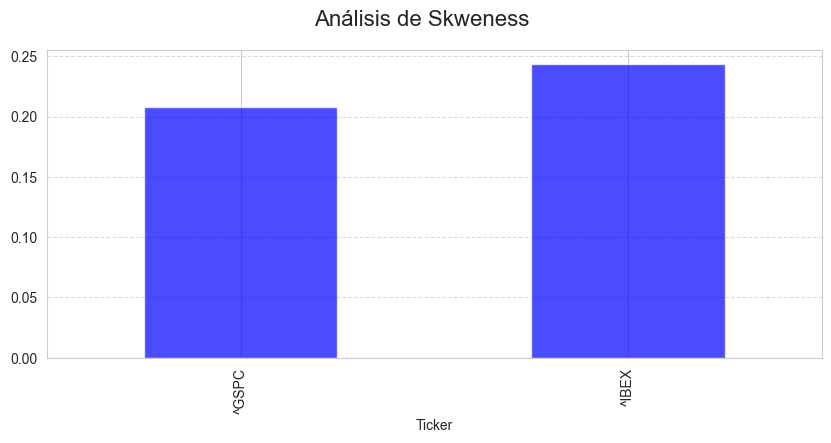

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
# Plot annual means
df_skew.plot(kind='bar', ax=ax, color='blue', alpha=0.7)

ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir un título general a la figura
plt.suptitle("Análisis de Skweness", fontsize=16)  # Título general

plt.show()

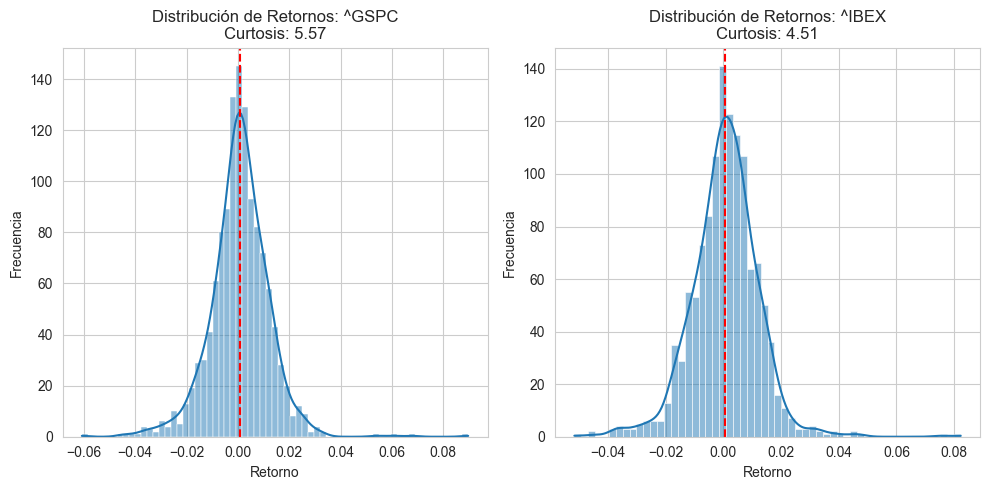

In [12]:
from scipy.stats import kurtosis

df= retornos
# Configurar el tamaño de la figura y el número de subplots
fig, axes = plt.subplots( ncols=2, figsize=(10, 5))

# Aplanar la matriz de ejes para iterar fácilmente
axes = axes.flatten()

# Crear un gráfico de distribución para cada columna del DataFrame en subplots
for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i])
    mean_value = df[column].mean()
    kurtosis_value = kurtosis(df[column])

    # Agregar una línea en la media
    axes[i].axvline(mean_value, color='r', linestyle='--')

    # Añadir título y etiquetas
    axes[i].set_title(f'Distribución de Retornos: {column}\nCurtosis: {kurtosis_value:.2f}')
    axes[i].set_xlabel('Retorno')
    axes[i].set_ylabel('Frecuencia')

# Eliminar cualquier subplot vacío
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para que no se superpongan los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [13]:
# Letras del tesoro Alemania- 12 meses- 2.1581 https://www.deutsche-finanzagentur.de/en/federal-securities/issuances/issuance-results#:~:text=24,1581 
# Letras del tesoro Español- 12 meses - 2,173 https://www.tesoro.es/deuda-publica/subastas/resultado-ultimas-subastas/letras-del-tesoro 
# Letras del tesoro USA: 3.905% https://treasurydirect.gov/instit/annceresult/press/preanre/2025/R_20250318_1.pdf 

In [ ]:
#Cálculo de valores medios y la desviación estándar de cada indice:
means = retornos.mean() * 252
stds = retornos.std() * np.sqrt(252)

rf = 0.02173  # tasa libre de riesgo- Letras a 12 meses
sharpe_indices = (means - rf) / stds

print("Retornos anuales")
print(means)
print("Desviaciones")
print(stds)
print("Indice Sharpe")
print(sharpe_indices)

Retornos anuales
Ticker
^GSPC    0.188128
^IBEX    0.154261
dtype: float64
Desviaciones
Ticker
^GSPC    0.183744
^IBEX    0.185644
dtype: float64
Indice Sharpe
Ticker
^GSPC    0.905600
^IBEX    0.713901
dtype: float64


In [ ]:
# Usamos 60 activos para escoger los activos que integraran la cartera 
# USA – Tecnológicas, Consumo, Salud (20)
# Europa – Industria, Energía, Banca (20)
# China – Tecnología, E-commerce, Autos (10)
# 10 Empresas Europeas 


tickers = [
    # USA (20)
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'COST', 'TSLA', 'NEE', 'PG', 'HD',
    'MCD', 'LRCX', 'MA', 'WMT', 'MSCI', 'PFE', 'UNH', 'ABNB', 'INTC', 'NFLX',

    # Europa (20)
    'SIE.DE', 'MC.PA', 'ASML.AS', 'NOVN.SW', 'SIE.DE', 'SAP.DE', 'TTE.PA',
    'ULVR.L', 'SAN.MC', 'BBVA.MC', 'IBE.MC', 'MC.PA', 'NESN.SW', 'VOW3.DE',
    'CS.PA', 'SU.PA', 'ROG.SW', 'AD.AS', 'KER.PA', 'HEIA.AS', "V", "LULU", "OR.PA",

    # China (10)
    'BABA', 'JD', 'BIDU', 'NIO', 'XPEV', '0700.HK', '3690.HK', 'LI', '1211.HK', 'NTES',

    # Sostenibles / Energía limpia (10)
    'FSLR', 'ENPH', 'PLUG', 'SEDG', 'ORSTED.CO', 'BEP', 'VWS.CO', 'NEE', 'RUN', "ORA"
]
 

In [16]:
# Downloading data
indices_prices = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    multi_level_index=True,
)['Adj Close']

[*********************100%***********************]  60 of 60 completed


<Axes: >

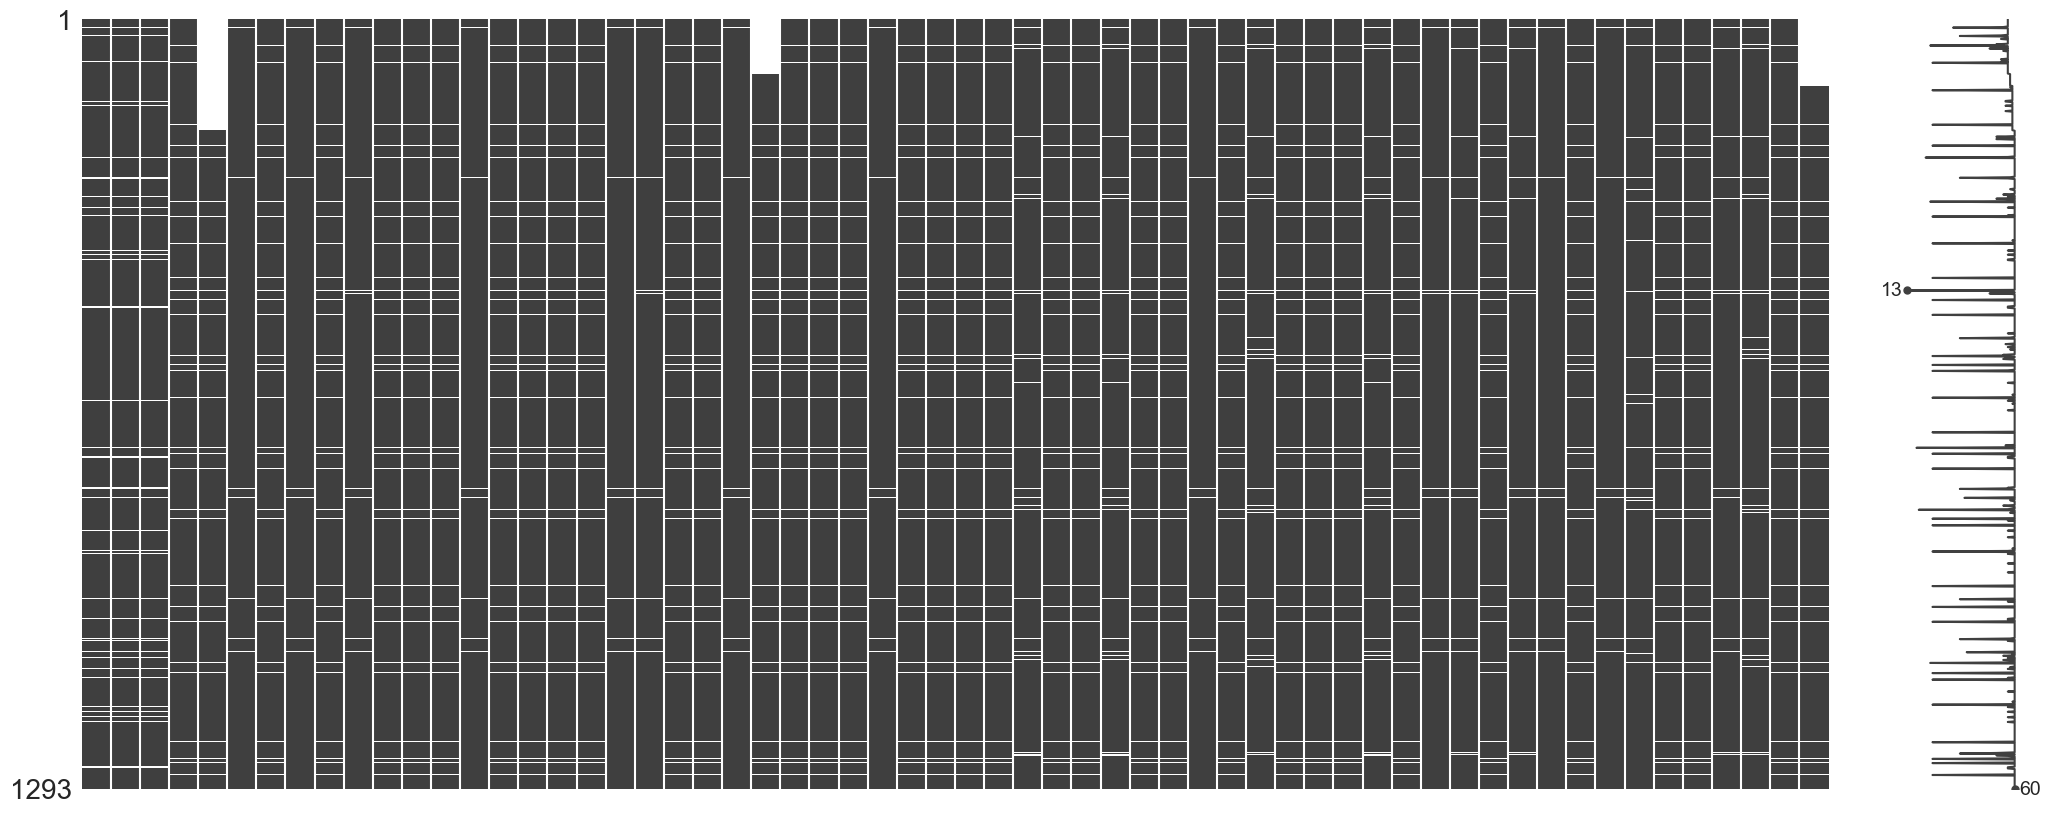

In [17]:
msno.matrix(indices_prices)

In [18]:
nulls = indices_prices.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)
print(nulls)

Ticker
ABNB         219
XPEV         146
LI           126
1211.HK       64
0700.HK       64
3690.HK       64
ORSTED.CO     40
VWS.CO        40
MSFT          36
AMZN          36
MA            36
RUN           36
MCD           36
MSCI          36
NEE           36
NFLX          36
LRCX          36
NIO           36
NTES          36
NVDA          36
PLUG          36
ORA           36
LULU          36
AAPL          36
PG            36
SEDG          36
WMT           36
BABA          36
BEP           36
BIDU          36
COST          36
V             36
ENPH          36
FSLR          36
GOOGL         36
HD            36
UNH           36
TSLA          36
INTC          36
JD            36
PFE           36
ROG.SW        32
NESN.SW       32
NOVN.SW       32
ULVR.L        31
SAP.DE        18
SIE.DE        18
VOW3.DE       18
IBE.MC        12
SAN.MC        12
BBVA.MC       12
HEIA.AS       10
ASML.AS       10
CS.PA         10
OR.PA         10
TTE.PA        10
SU.PA         10
KER.PA        10
MC.PA  

In [ ]:
# Selección inicial de 60 activos para primer análisis de cartera optima 
# USA – Tecnológicas, Consumo, Salud (20)
# Europa – Industria, Energía, Banca (20)
# China – Tecnología, E-commerce, Autos (10)
# 10 Empresas Europeas 

#IBEX.MC
#Geely Automobile	0175.HK	🇨🇳	Fuerte presencia en China + EV
# Pinduoduo Inc. (PDD) Sector: Comercio electrónico (ecommerce social)
# COST costco wholesale
# LRCX Lam research - semiconductores
#Intercambiamos los valores que anteriormente presentaron mas datos missing 


tickers = [
    # USA (20)
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'COST', 'TSLA', 'NEE', 'PG', 'KO',
    'MCD', 'VRTX', 'MA', 'WMT', 'MSCI', 'PFE', 'UNH', 'BTC-USD', 'INTC', 'NFLX',

    # Europa (20)
    'SIE.DE', 'MC.PA', 'ASML.AS', 'NOVN.SW', 'SIE.DE', 'SAP.DE', 'TTE.PA',
    'ULVR.L', 'SAN.MC', 'BBVA.MC', 'IBE.MC', 'MC.PA', 'NESN.SW', 'VOW3.DE',
    'CS.PA', 'SU.PA', 'ROG.SW', 'AD.AS', 'KER.PA', 'HEIA.AS', "LULU", "OR.PA", "REP.MC",

    # China (10)
    'BABA', 'JD', 'BIDU', 'NIO', 'PDD', '0700.HK', '3690.HK', '0175.HK', '1211.HK', 'NTES',

    # Sostenibles / Energía limpia (10)
    'FSLR', 'ENPH', 'PLUG', 'SEDG', 'ORSTED.CO', 'BEP', 'VWS.CO', 'NEE', 'RUN', "ORA"

]

In [20]:
indices_p = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    multi_level_index=True,
)['Adj Close']

[*********************100%***********************]  60 of 60 completed


<Axes: >

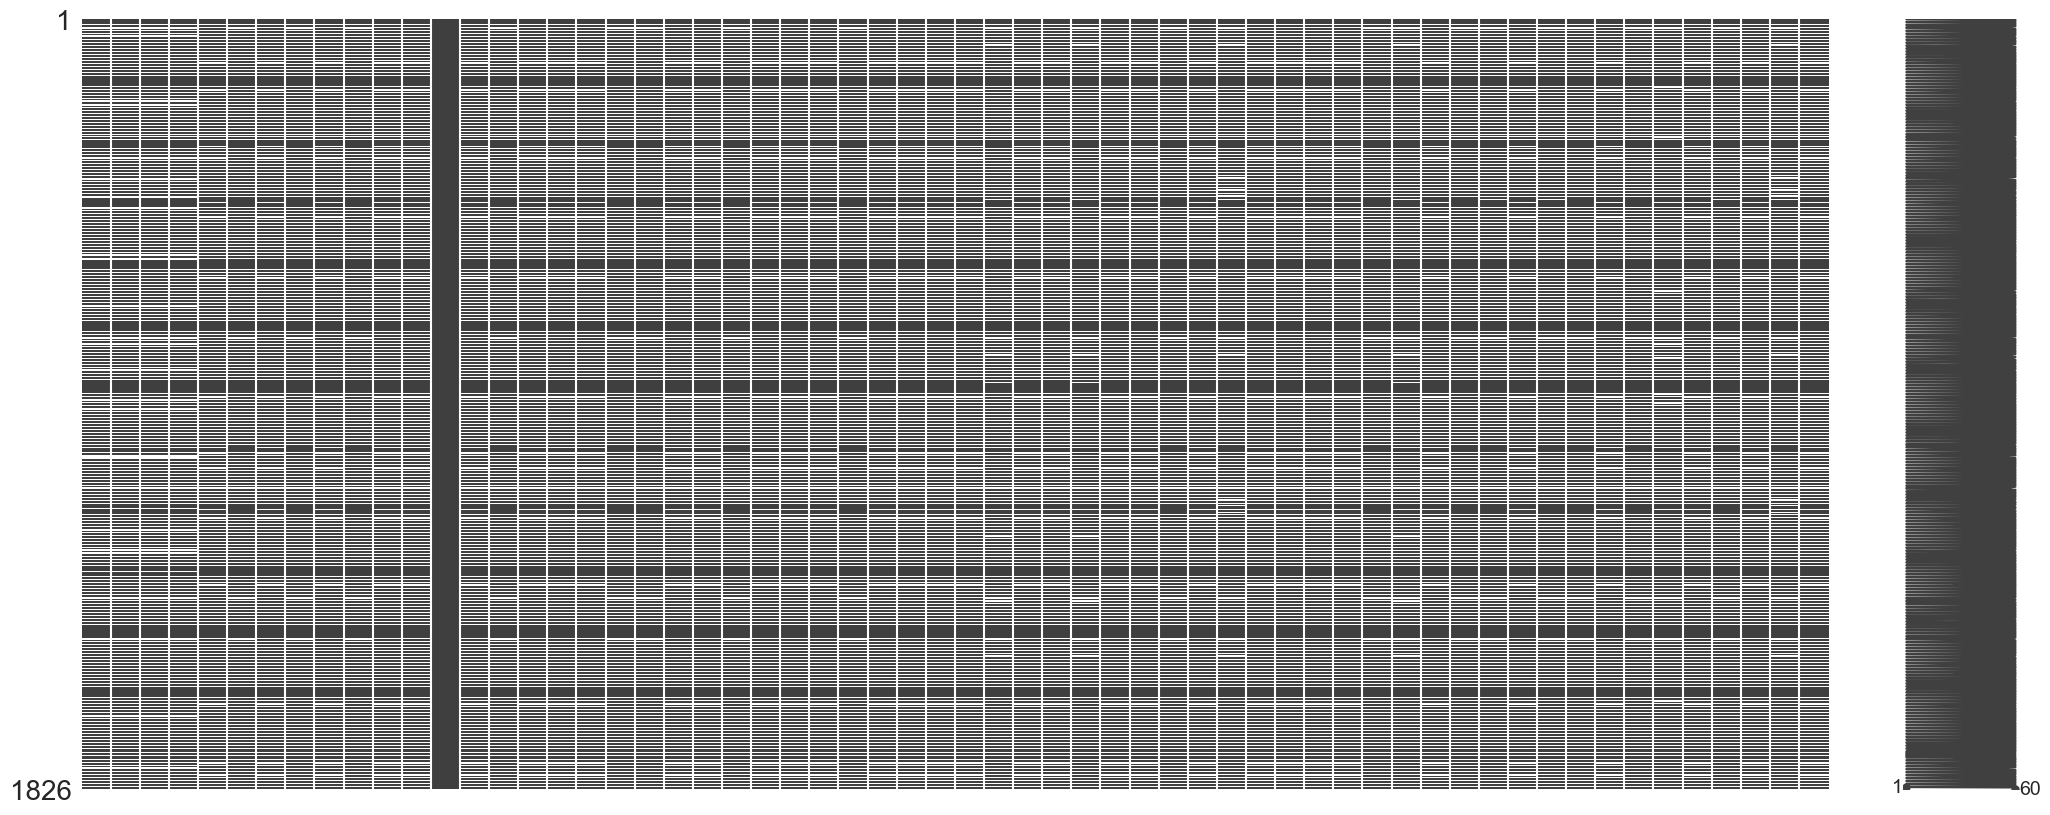

In [21]:
msno.matrix(indices_p)

In [22]:
nulls = indices_p.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)
print(nulls)

Ticker
0175.HK      597
1211.HK      597
3690.HK      597
0700.HK      597
ORSTED.CO    573
VWS.CO       573
MSCI         569
MSFT         569
NFLX         569
NIO          569
NTES         569
NVDA         569
ORA          569
PFE          569
PDD          569
MA           569
PG           569
PLUG         569
RUN          569
SEDG         569
TSLA         569
UNH          569
VRTX         569
MCD          569
NEE          569
BEP          569
GOOGL        569
AAPL         569
AMZN         569
BABA         569
LULU         569
BIDU         569
COST         569
ENPH         569
FSLR         569
WMT          569
KO           569
INTC         569
JD           569
NOVN.SW      565
NESN.SW      565
ROG.SW       565
ULVR.L       564
SAP.DE       551
SIE.DE       551
VOW3.DE      551
IBE.MC       545
REP.MC       545
BBVA.MC      545
SAN.MC       545
AD.AS        543
KER.PA       543
OR.PA        543
TTE.PA       543
ASML.AS      543
SU.PA        543
HEIA.AS      543
CS.PA        543
MC.PA  

<Axes: >

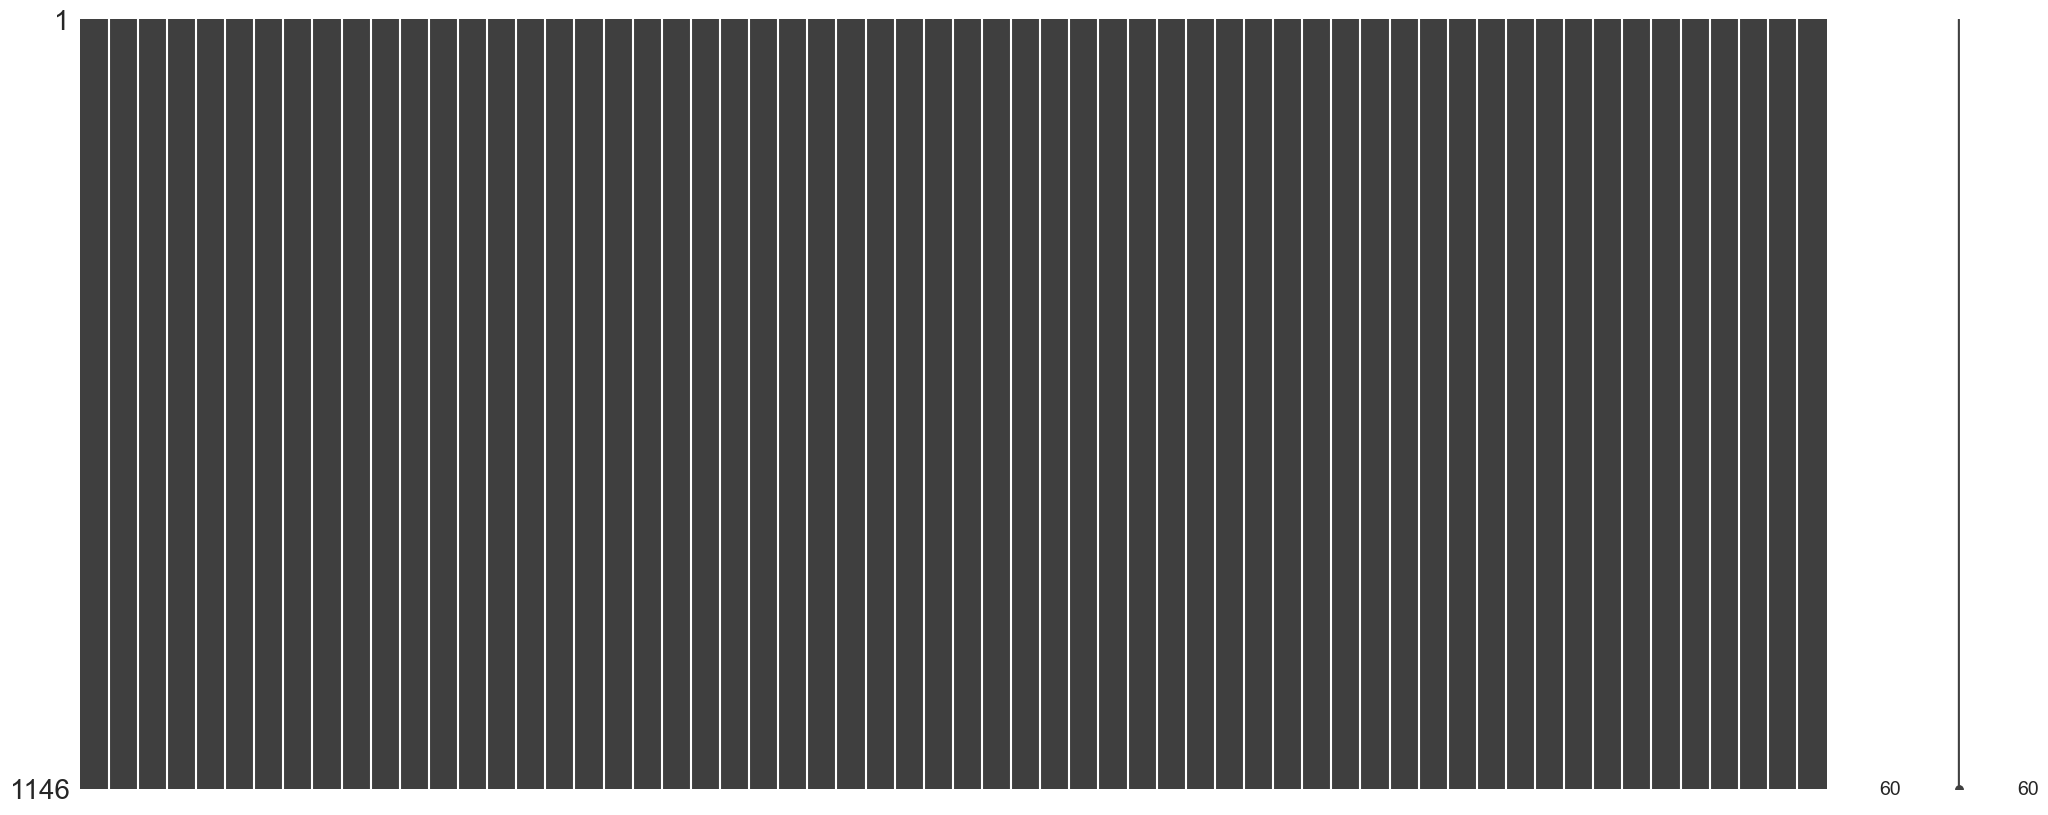

In [23]:
#Eliminar las filas con nulos
indices_p= indices_p.dropna(axis=0,how='any')

msno.matrix(indices_p)

In [24]:
indices_p.shape

(1146, 60)

<Axes: xlabel='Date'>

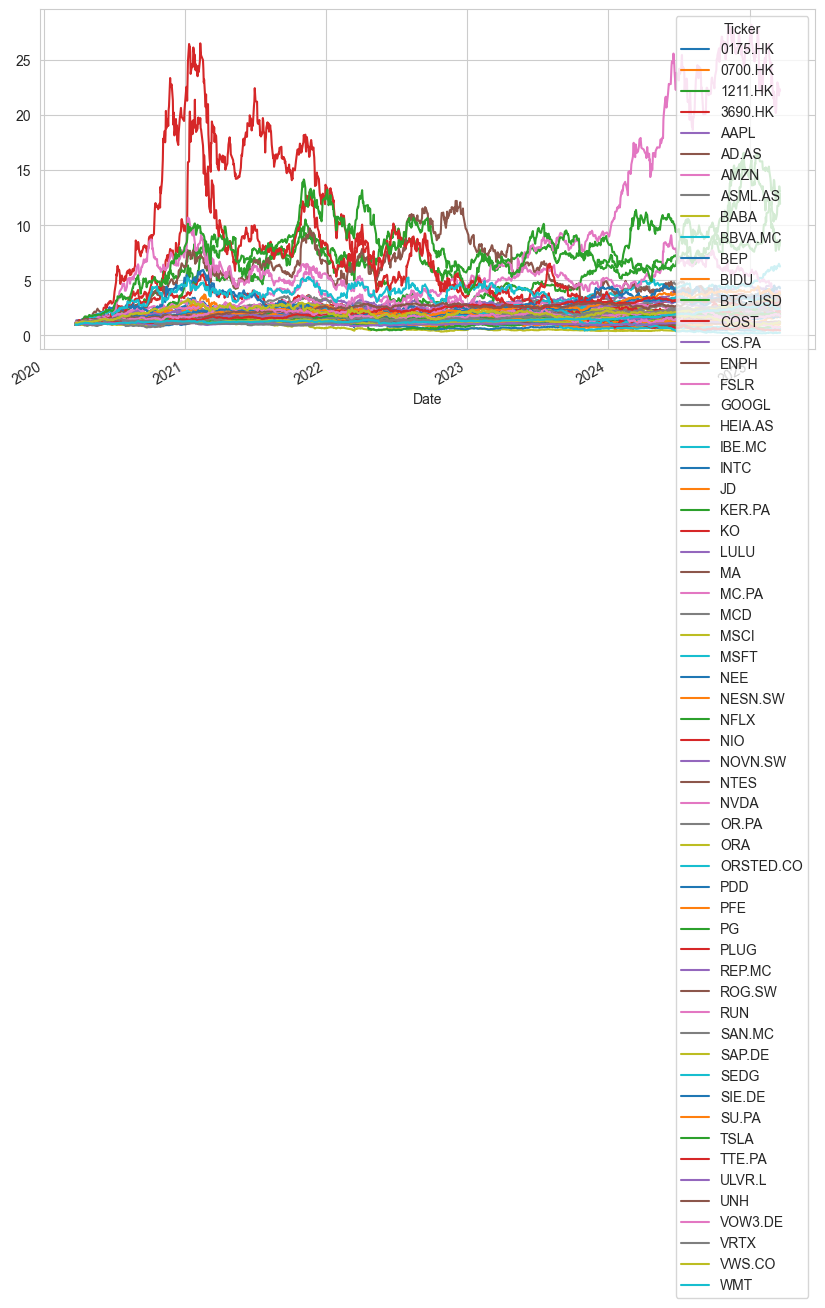

In [25]:
activos_precios = indices_p/indices_p.iloc[0, :]

activos_precios.plot(figsize=(10, 5))

In [26]:
retornos_activos= np.log(activos_precios).diff().dropna()

<Axes: xlabel='Date'>

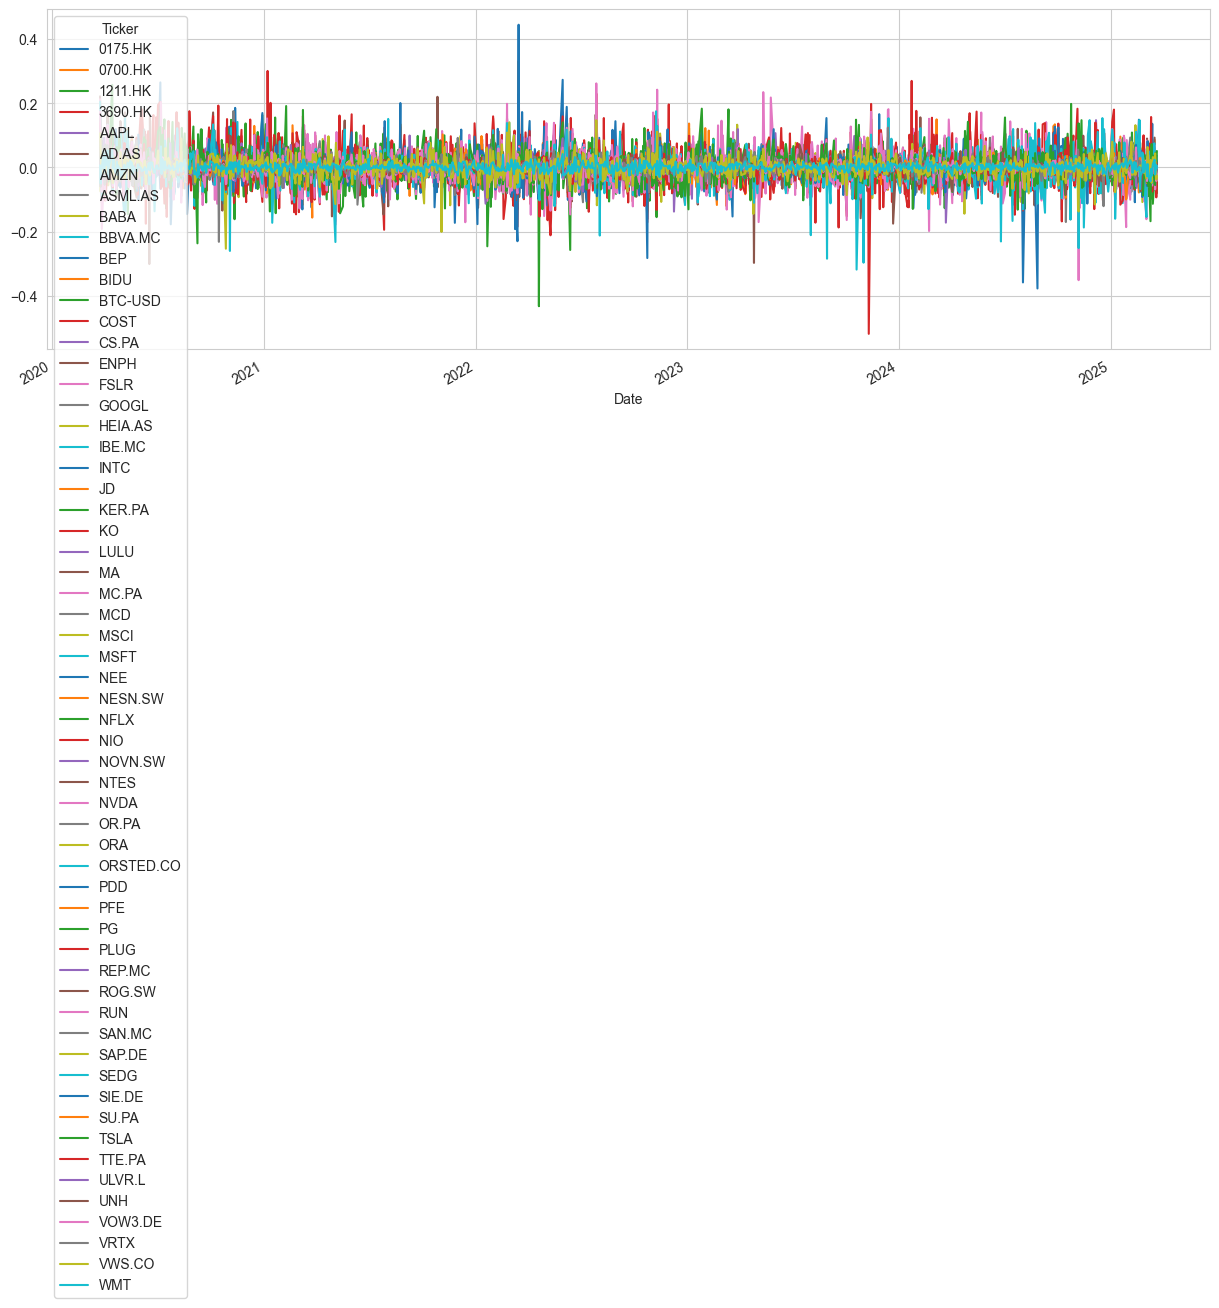

In [27]:
retornos_activos.plot(figsize=(15, 5))

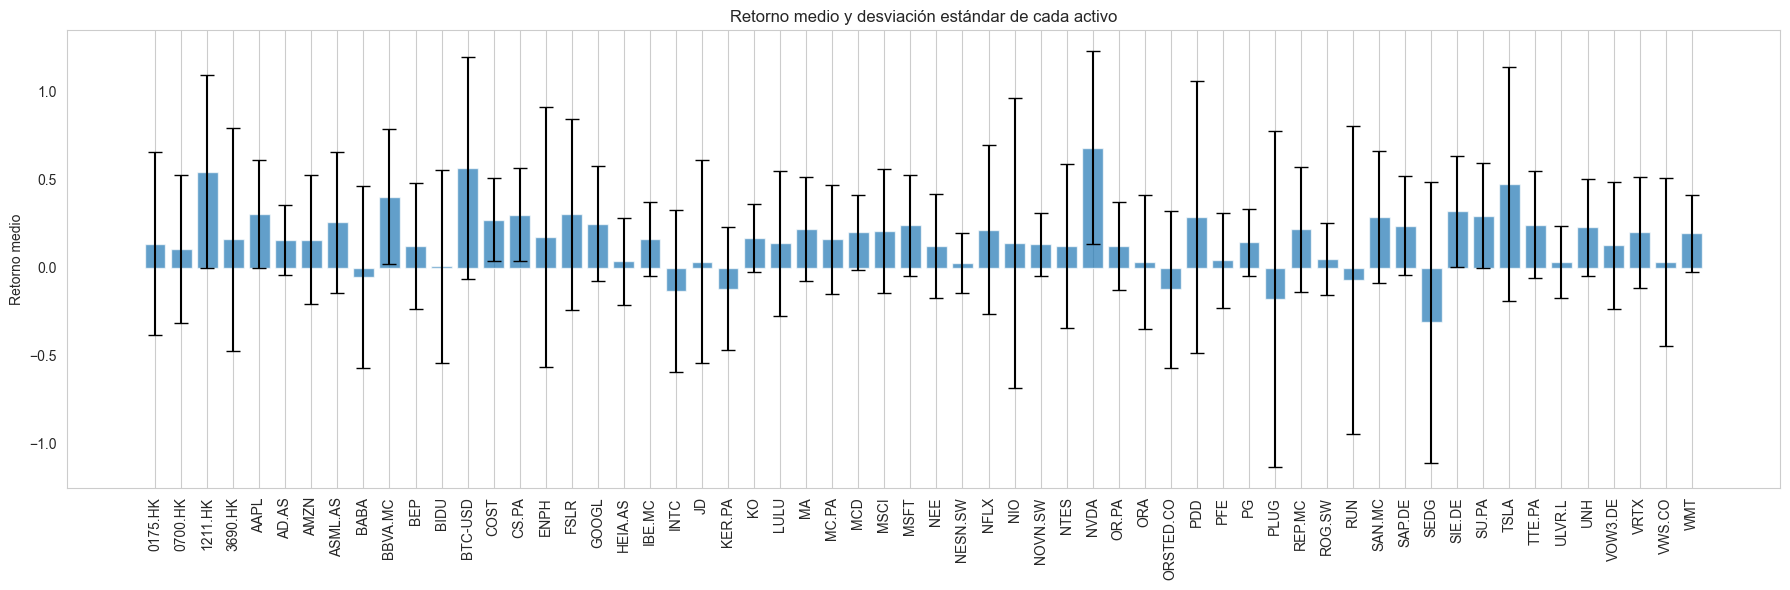

In [ ]:
import matplotlib.pyplot as plt

# Calcular media y desviación estándar de cada activo
media = retornos_activos.mean()*252
desviacion = retornos_activos.std() * np.sqrt(252)

# Crear el gráfico de barras rangos de movimiento de la desviación 
plt.figure(figsize=(18, 6))
plt.bar(media.index, media.values, yerr=desviacion.values, capsize=5, alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel('Retorno medio')
plt.title('Retorno medio y desviación estándar de cada activo')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [29]:
desviacion

Ticker
0175.HK      0.520623
0700.HK      0.420403
1211.HK      0.547288
3690.HK      0.633747
AAPL         0.305666
AD.AS        0.201324
AMZN         0.364801
ASML.AS      0.400981
BABA         0.516318
BBVA.MC      0.384913
BEP          0.358394
BIDU         0.546684
BTC-USD      0.629896
COST         0.235830
CS.PA        0.263862
ENPH         0.738010
FSLR         0.543812
GOOGL        0.326987
HEIA.AS      0.245957
IBE.MC       0.210614
INTC         0.459078
JD           0.574542
KER.PA       0.349382
KO           0.192936
LULU         0.409429
MA           0.293819
MC.PA        0.308679
MCD          0.211665
MSCI         0.352072
MSFT         0.286574
NEE          0.293832
NESN.SW      0.169733
NFLX         0.479302
NIO          0.821200
NOVN.SW      0.181332
NTES         0.467346
NVDA         0.547323
OR.PA        0.250562
ORA          0.380610
ORSTED.CO    0.447972
PDD          0.772789
PFE          0.271331
PG           0.188762
PLUG         0.952958
REP.MC       0.354030
ROG

C:\Users\karen\AppData\Local\Temp\ipykernel_25116\2477113239.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(desviacion[i], media[i], media.index[i], fontsize=9)


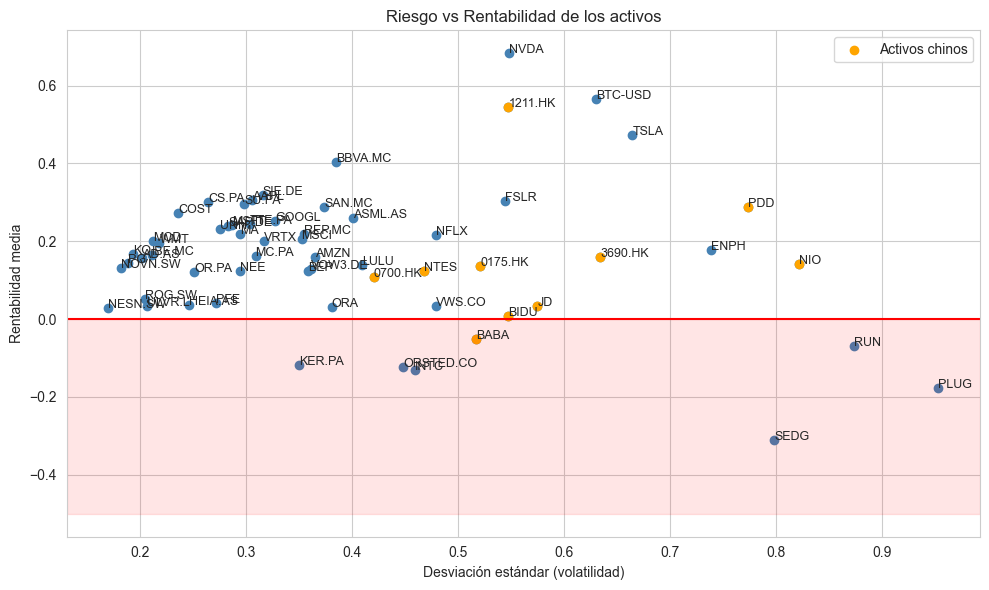

In [30]:
# Lista de activos chinos
activos_chinos = ['BABA', 'JD', 'BIDU', 'NIO', 'PDD', '0700.HK', '3690.HK', '0175.HK', '1211.HK', 'NTES']

plt.figure(figsize=(10, 6))

# Puntos por defecto (todos en azul)
plt.scatter(desviacion, media, color='steelblue')

# Puntos chinos en naranja
plt.scatter(
    desviacion[activos_chinos],
    media[activos_chinos],
    color='orange',
    label='Activos chinos'
)

# Línea roja en y = 0 (eje X)
plt.axhline(0, color='red', linewidth=1.5)

# Sombrear el área por debajo del eje X
plt.axhspan(-0.5, 0, color='red', alpha=0.1)

# Etiquetas para todos los activos
for i in range(len(media)):
    plt.text(desviacion[i], media[i], media.index[i], fontsize=9)

plt.xlabel('Desviación estándar (volatilidad)')
plt.ylabel('Rentabilidad media')
plt.title('Riesgo vs Rentabilidad de los activos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
from IPython.display import display

# Filtrar activos que cumplen con los criterios
candidatos = media[(media > 0.12) & (desviacion < 0.4)].index

# Crear tabla resumen con Sharpe ratio (tasa libre de riesgo del 3%)
candidatos_df = pd.DataFrame({
    'Rentabilidad anual (%)': media[candidatos] * 100,
    'Volatilidad anual (%)': desviacion[candidatos] * 100,
    'Sharpe ratio': (media[candidatos] - rf) / desviacion[candidatos]
}).sort_values('Sharpe ratio', ascending=False)

display(candidatos_df)
len(candidatos)

,Rentabilidad anual (%),Volatilidad anual (%),Sharpe ratio
Ticker,,,
COST,27.328652,23.583018,1.066685
CS.PA,29.981725,26.386160,1.053913
BBVA.MC,40.379073,38.491316,0.992589
SIE.DE,31.974043,31.549637,0.944576
AAPL,30.558066,30.566624,0.928629
SU.PA,29.473479,29.771645,0.916996
MCD,20.167117,21.166454,0.850124
WMT,19.530227,21.797372,0.796299
MSFT,24.223462,28.657381,0.769451


29

C:\Users\karen\AppData\Local\Temp\ipykernel_25116\2733409744.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(desviacion_filtrada[i], media_filtrada[i], media_filtrada.index[i], fontsize=9)


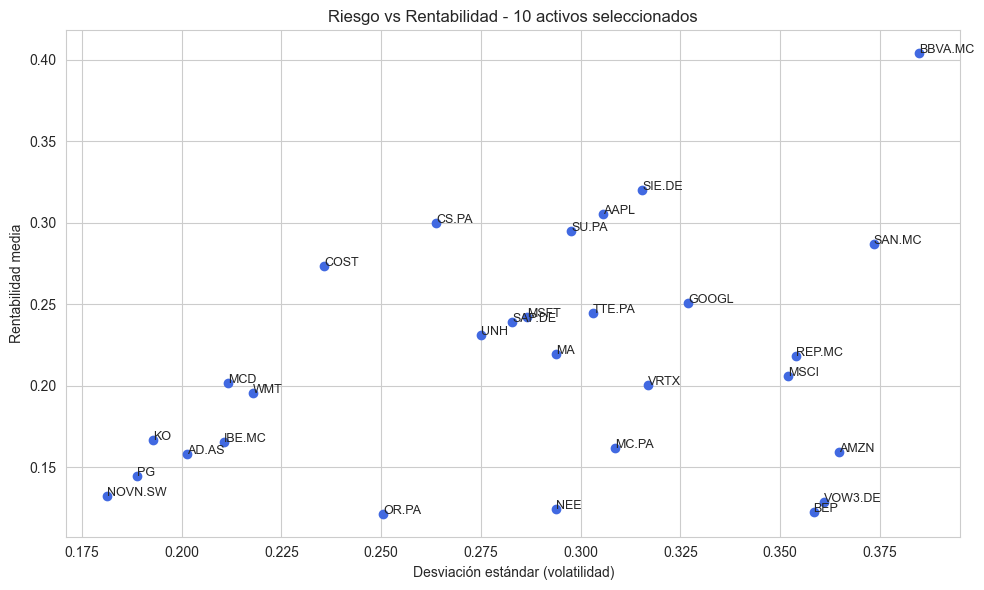

In [32]:
plt.figure(figsize=(10, 6))

# Extraer los datos filtrados
media_filtrada = media[candidatos]
desviacion_filtrada = desviacion[candidatos]

# Graficar
plt.scatter(desviacion_filtrada, media_filtrada, color='royalblue')

# Etiquetas
for i in range(len(media_filtrada)):
    plt.text(desviacion_filtrada[i], media_filtrada[i], media_filtrada.index[i], fontsize=9)

plt.xlabel('Desviación estándar (volatilidad)')
plt.ylabel('Rentabilidad media')
plt.title('Riesgo vs Rentabilidad - 10 activos seleccionados')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
retornos

Ticker,^GSPC,^IBEX
Date,,
2020-03-24,0.089683,0.075278
2020-03-25,0.011469,0.032961
2020-03-26,0.060544,0.012994
2020-03-27,-0.034268,-0.036975
2020-03-30,0.032967,-0.017563
...,...,...
2025-03-17,0.006396,0.010860
2025-03-18,-0.010711,0.015660
2025-03-19,0.010741,0.003991


In [34]:
a_cartera= ['COST', 'CS.PA', 'AAPL','SIE.DE','MCD','WMT','KO','PG','NOVN.SW','BBVA.MC']

# Filtrar retornos diarios para los activos seleccionados
retornos_cartera = retornos_activos[a_cartera].dropna()

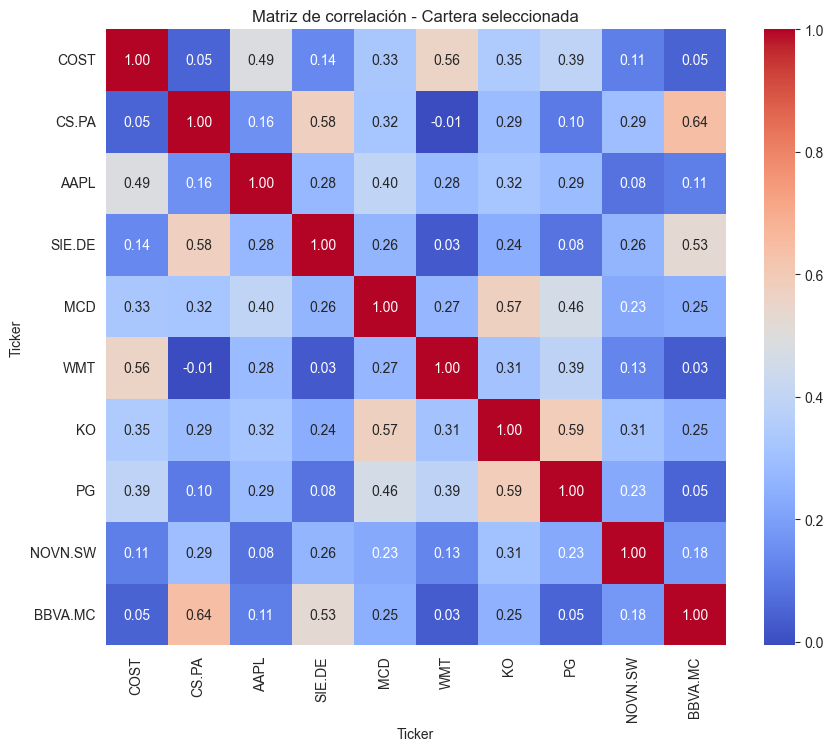

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(retornos_cartera.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación - Cartera seleccionada')
plt.show()

In [36]:
# En general, la distribución dispersa y moderadamente baja de correlaciones confirma que la cartera está formada por activos con patrones distintos, lo que contribuye a una menor volatilidad total.
# Esto apoya el alto ratio de Sharpe obtenido: no solo hay buena rentabilidad esperada, sino que el riesgo está eficientemente diversificado.

In [56]:
# Calcula la correlación media entre los activos de tu cartera, ignorando la diagonal (es decir, sin contar las autocorrelaciones de 1.0 de cada activo consigo mismo).
correlacion_media = retornos_cartera.corr().where(~np.eye(retornos_cartera.shape[1],dtype=bool)).mean().mean()
print(f"Correlación promedio entre activos: {correlacion_media:.2f}")

"""retornos_cartera.corr()
→ Calcula la matriz de correlación de los retornos diarios (entre -1 y 1).

np.eye(retornos_cartera.shape[1], dtype=bool)
→ Crea una matriz identidad del mismo tamaño, con True en la diagonal principal.
Ej: si tienes 3 activos, esto sería:

graphql
Copiar
Editar
[[ True, False, False],
 [False,  True, False],
 [False, False,  True]]
~
→ Invierte los valores booleanos: True → False, y False → True.
Así, solo quedan True en los elementos fuera de la diagonal.

.where(...)
→ Mantiene los valores de la correlación solo en los lugares True (fuera de la diagonal), y pone NaN en la diagonal (autocorrelación de 1.0 que no queremos incluir).

.mean().mean()
→ Calcula primero la media por columna, y luego la media global de todas esas medias:
Resultado final = media de todas las correlaciones cruzadas entre los activos."""

Correlación promedio entre activos: 0.27


'retornos_cartera.corr()\n→ Calcula la matriz de correlación de los retornos diarios (entre -1 y 1).\n\nnp.eye(retornos_cartera.shape[1], dtype=bool)\n→ Crea una matriz identidad del mismo tamaño, con True en la diagonal principal.\nEj: si tienes 3 activos, esto sería:\n\ngraphql\nCopiar\nEditar\n[[ True, False, False],\n [False,  True, False],\n [False, False,  True]]\n~\n→ Invierte los valores booleanos: True → False, y False → True.\nAsí, solo quedan True en los elementos fuera de la diagonal.\n\n.where(...)\n→ Mantiene los valores de la correlación solo en los lugares True (fuera de la diagonal), y pone NaN en la diagonal (autocorrelación de 1.0 que no queremos incluir).\n\n.mean().mean()\n→ Calcula primero la media por columna, y luego la media global de todas esas medias:\nResultado final = media de todas las correlaciones cruzadas entre los activos.'

In [38]:
#“La correlación promedio de la cartera es baja (0.27), lo que confirma que el diseño busca maximizar la eficiencia en la relación riesgo/rentabilidad.”

In [39]:
import numpy as np
from scipy.optimize import minimize #Minimize, libreria de optimización https://docs.scipy.org/doc/scipy/tutorial/optimize.html

# Datos anuales  
media_anual = retornos_cartera.mean() * 252  # Cálculo de la rentabilidad media anual de cada activo (media diaria * 252 días)
cov_anual = retornos_cartera.cov() * 252     # Matriz de covarianza anual de los retornos (cov diaria * 252)
num_activos = len(a_cartera)                 # Número total de activos en la cartera

# Función objetivo: minimizar la Sharpe ratio negativa
def sharpe_negativa(pesos, media, cov, rf=rf ):
    ret = np.dot(pesos, media)                        # Rentabilidad esperada de la cartera (media ponderada)
    vol = np.sqrt(np.dot(pesos.T, np.dot(cov, pesos))) # Volatilidad total de la cartera (desviación estándar)
    sharpe = (ret - rf) / vol                          # Cálculo del ratio de Sharpe
    return -sharpe                                     # Se devuelve el negativo porque se desea maximizar el Sharpe (y minimize solo minimiza)

# Restricción: los pesos deben sumar 1 (100% del capital invertido)
restricciones = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Límites de los pesos: cada peso entre 0 y 1 (sin ventas en corto)
limites = tuple((0, 1) for _ in range(num_activos))

# Pesos iniciales: todos los activos con el mismo peso al inicio (1/N)
pesos_iniciales = np.array([1/num_activos] * num_activos)

# Optimización para encontrar los pesos óptimos que maximizan el ratio de Sharpe
resultado = minimize(
    sharpe_negativa,              # Función objetivo
    pesos_iniciales,              # Punto de partida
    args=(media_anual, cov_anual),# Parámetros de la función
    method='SLSQP',               # Método de optimización cuadrática secuencial
    bounds=limites,               # Límites permitidos para cada peso
    constraints=restricciones     # Restricción de suma de pesos = 1
)

# Resultado final: vector con los pesos óptimos para la cartera
pesos_optimos = resultado.x

In [40]:
# Tabla resumen con pesos en porcentaje
cartera_optima = pd.DataFrame({
    'Activo': a_cartera,
    'Peso óptimo (%)': (pesos_optimos * 100).round(2)
}).sort_values('Peso óptimo (%)', ascending=False)

display(cartera_optima)

# Métricas finales (ya estaban bien en porcentaje)
ret_opt = np.dot(pesos_optimos, media_anual)
vol_opt = np.sqrt(np.dot(pesos_optimos.T, np.dot(cov_anual, pesos_optimos)))
sharpe_opt = (ret_opt - rf) / vol_opt

print(f"Rentabilidad esperada anual: {ret_opt:.2%}")
print(f"Volatilidad esperada anual: {vol_opt:.2%}")
print(f"Sharpe ratio de la cartera: {sharpe_opt:.2f}")

,Activo,Peso óptimo (%)
0,COST,26.25
1,CS.PA,19.09
5,WMT,12.75
9,BBVA.MC,11.65
2,AAPL,10.04
8,NOVN.SW,9.69
3,SIE.DE,5.08
4,MCD,2.78
7,PG,2.68
6,KO,0.00


Rentabilidad esperada anual: 27.01%
Volatilidad esperada anual: 15.64%
Sharpe ratio de la cartera: 1.59


In [41]:
!pip install ace_tools

In [54]:
cartera_resumen= cartera_optima.copy()

# Información complementaria manualmente añadida
info = {
    'COST': {'País': 'USA', 'Sector': 'Retail / Mayoristas (Costco)'},
    'CS.PA': {'País': 'Francia', 'Sector': 'Lujo / Bienes de consumo (LVMH)'},
    'WMT': {'País': 'USA', 'Sector': 'Retail (Walmart)'},
    'BBVA.MC': {'País': 'España', 'Sector': 'Banca (BBVA)'},
    'AAPL': {'País': 'USA', 'Sector': 'Tecnología (Apple)'},
    'NOVN.SW': {'País': 'Suiza', 'Sector': 'Farmacéutica (Novartis)'},
    'SIE.DE': {'País': 'Alemania', 'Sector': 'Industria / Tecnología (Siemens)'},
    'MCD': {'País': 'USA', 'Sector': 'Comida rápida (McDonald\'s)'},
    'PG': {'País': 'USA', 'Sector': 'Bienes de consumo (Procter & Gamble)'},
    'KO': {'País': 'USA', 'Sector': 'Bebidas / Consumo (Coca-Cola)'}
}

# Añadir país y sector a la tabla
cartera_resumen['País'] = cartera_resumen['Activo'].map(lambda x: info[x]['País'])
cartera_resumen['Sector'] = cartera_resumen['Activo'].map(lambda x: info[x]['Sector'])

cartera_resumen 

,Activo,Peso óptimo (%),País,Sector
0,COST,26.25,USA,Retail / Mayoristas (Costco)
1,CS.PA,19.09,Francia,Lujo / Bienes de consumo (LVMH)
5,WMT,12.75,USA,Retail (Walmart)
9,BBVA.MC,11.65,España,Banca (BBVA)
2,AAPL,10.04,USA,Tecnología (Apple)
8,NOVN.SW,9.69,Suiza,Farmacéutica (Novartis)
3,SIE.DE,5.08,Alemania,Industria / Tecnología (Siemens)
4,MCD,2.78,USA,Comida rápida (McDonald's)
7,PG,2.68,USA,Bienes de consumo (Procter & Gamble)
6,KO,0.00,USA,Bebidas / Consumo (Coca-Cola)


In [43]:
# COST y CS.PA apenas tienen correlación (0.05)
# AAPL y NOVN.SW tienen solo 0.11
# BBVA.MC tiene correlaciones bajas con casi todos, lo cual aporta valor diversificador desde Europa
# Esto es una señal clara de diversificación efectiva, ya que permite que el riesgo de mercado no se concentre en un mismo tipo de comportamiento.

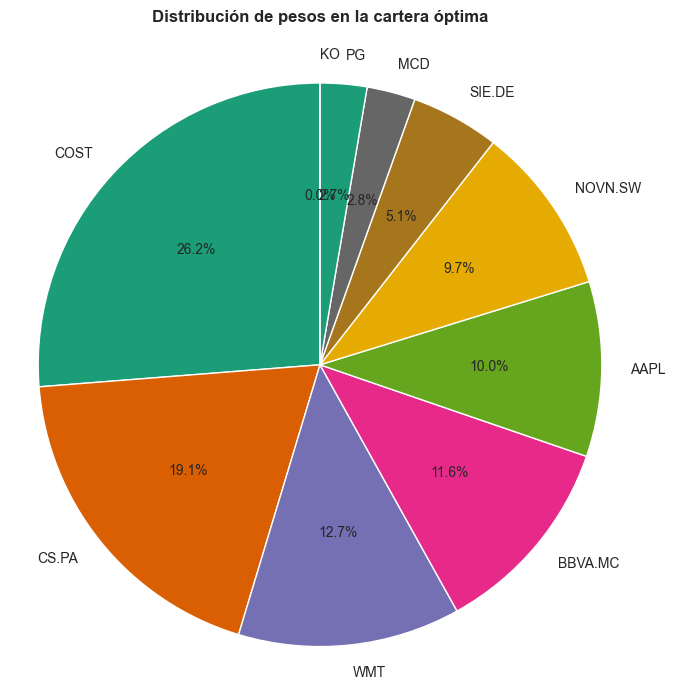

In [44]:
# Elegir una paleta de Seaborn (por nombre o colores)
colores = sns.color_palette("Dark2", n_colors=len(cartera_optima))

# Usarlo en Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(
    cartera_optima['Peso óptimo (%)'],
    labels=cartera_optima['Activo'],
    colors=colores,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribución de pesos en la cartera óptima', pad=25, fontweight= "semibold")
plt.axis('equal')
plt.show()

In [45]:
#Vamos a comparar el Sharpe ratio de tu cartera (1.54) con el de dos ETFs de referencia:
# SPY: representa al S&P 500- tiene close (sin dividendos)- yf no proporciona el adj close para SPY
# IQQ0.DE: ETF del IBEX 35 con dividendos- no tiene dato de adj close (sin dividendos)-  yf no proporciona el adj close para IQQ0.DE

# ETFs a comparar
etfs = ['SPY', 'IQQ0.DE']

# Descargar datos
datos_etfs = yf.download(etfs, start=start_date, end=end_date, group_by='ticker')

# Extraer precios adecuados para cada ETF
precios_etfs = pd.DataFrame()
precios_etfs['SPY'] = datos_etfs['SPY']['Close']  # con dividendos
precios_etfs['IQQ0.DE'] = datos_etfs['IQQ0.DE']['Close']  # sin dividendos, porque no hay 'Adj Close'

# Calcular retornos diarios
retornos_etfs = precios_etfs.pct_change().dropna()

# Rentabilidad y volatilidad anualizadas
media_etfs = retornos_etfs.mean() * 252
vol_etfs = retornos_etfs.std() * np.sqrt(252)
sharpe_etfs = (media_etfs - rf) / vol_etfs

# Crear tabla resumen
resumen_etfs = pd.DataFrame({
    'Rentabilidad anual (%)': media_etfs * 100,
    'Volatilidad anual (%)': vol_etfs * 100,
    'Sharpe Ratio': sharpe_etfs
}).round(2)

display(resumen_etfs)


[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed
C:\Users\karen\AppData\Local\Temp\ipykernel_25116\438141623.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos_etfs = precios_etfs.pct_change().dropna()


,Rentabilidad anual (%),Volatilidad anual (%),Sharpe Ratio
SPY,21.15,17.97,1.06
IQQ0.DE,12.12,11.46,0.87


In [55]:
# Tabla índices
indices_df = pd.DataFrame({
    'Rentabilidad anual (%)': means * 100,
    'Volatilidad anual (%)': stds * 100,
    'Sharpe Ratio': sharpe_indices
}).round(2)
indices_df.index.name = 'Activo'

# Añadir ETFs ya calculados
etfs_df = resumen_etfs.copy()
etfs_df.index.name = 'Activo'

# Añadir tu cartera
cartera_df = pd.DataFrame({
    'Rentabilidad anual (%)': [ret_opt * 100],
    'Volatilidad anual (%)': [vol_opt * 100],
    'Sharpe Ratio': [sharpe_opt]
}, index=['Cartera 007']).round(2)

# Unir todo
comparacion_total = pd.concat([indices_df, etfs_df, cartera_df])
comparacion_total = comparacion_total.loc[['^GSPC', '^IBEX', 'SPY', 'IQQ0.DE', 'Cartera 007']]

In [57]:
display(comparacion_total)

,Rentabilidad anual (%),Volatilidad anual (%),Sharpe Ratio
^GSPC,18.81,18.37,0.91
^IBEX,15.43,18.56,0.71
SPY,21.15,17.97,1.06
IQQ0.DE,12.12,11.46,0.87
Cartera 007,27.01,15.64,1.59


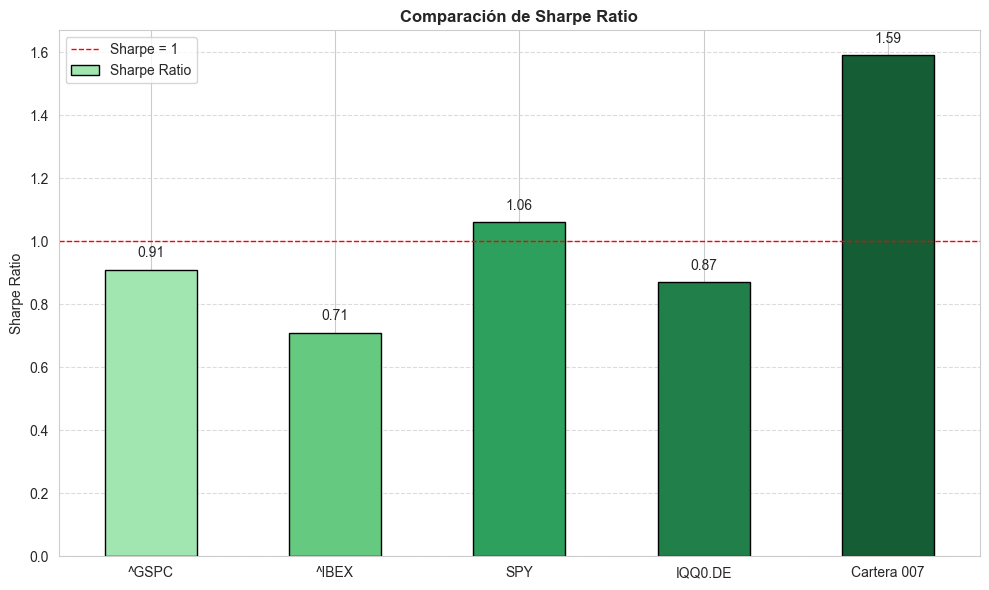

In [49]:
# Extraemos los Sharpe ratios del DataFrame ya unificado
sharpe_plot = comparacion_total['Sharpe Ratio']

# Gráfico de barras
plt.figure(figsize=(10, 6))
sharpe_plot.plot(kind='bar', color=['#a1e5b1',  # Verde menta claro
         '#65c980',  # Verde fresco medio
         '#2ca05c',  # Verde base (tu color)
         '#21804a',  # Verde bosque
         '#155d35']  # Verde oscuro profundo
        , edgecolor='black')

# Detalles del gráfico
plt.title('Comparación de Sharpe Ratio', fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Línea de referencia: Sharpe = 1
plt.axhline(1, color='red', linestyle='--', linewidth=1, label='Sharpe = 1')

# Mostrar valores sobre cada barra
for i, val in enumerate(sharpe_plot):
    plt.text(i, val + 0.03, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

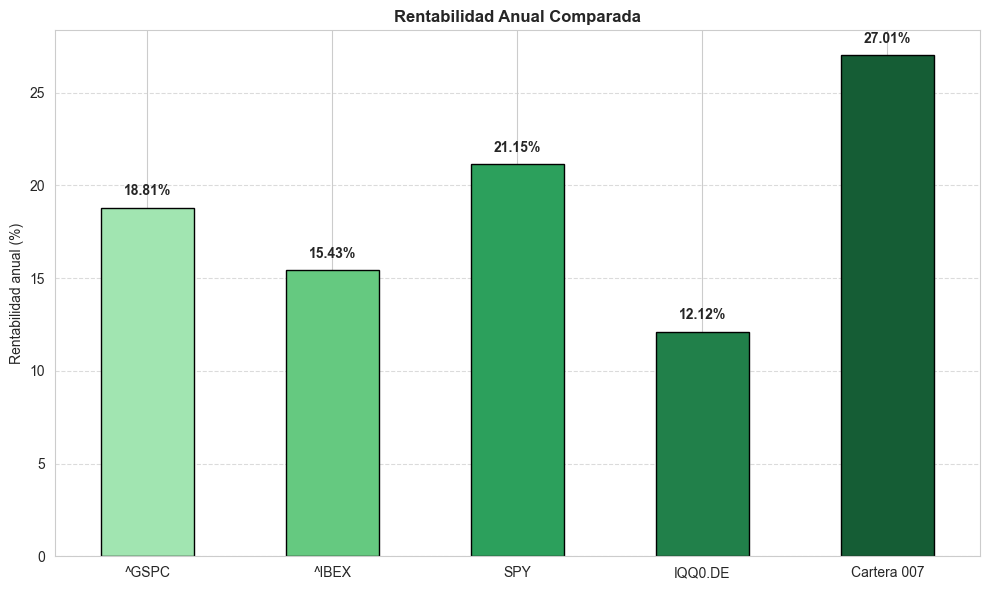

In [50]:
# Extraer rentabilidades anuales del DataFrame total
rent_plot = comparacion_total['Rentabilidad anual (%)']

# Paleta sugerida centrada en verde (#2ca05c)
color_rent = ['#a1e5b1', '#65c980', '#2ca05c', '#21804a', '#155d35']

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
rent_plot.plot(kind='bar', color=color_rent, edgecolor='black')

# Título y etiquetas
plt.title('Rentabilidad Anual Comparada', fontweight='bold')
plt.ylabel('Rentabilidad anual (%)')
plt.xticks(rotation=00)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores sobre las barras
for i, val in enumerate(rent_plot):
    plt.text(i, val + 0.5, f'{val:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\karen\AppData\Local\Temp\ipykernel_25116\1033164348.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(desviacion_plot[i], media_plot[i], media_plot.index[i], fontsize=10, ha='center', va='bottom')


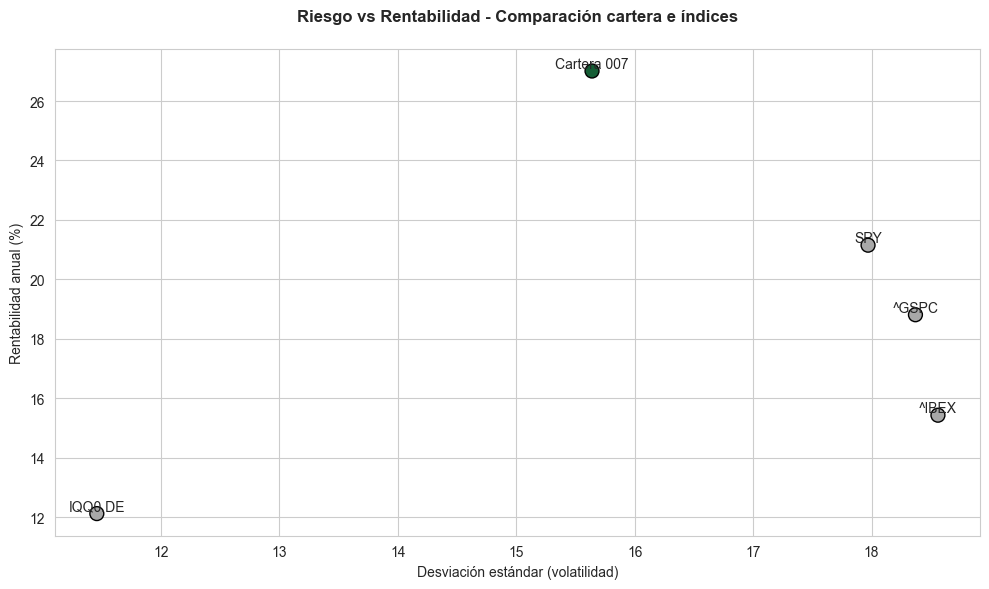

In [51]:
# Extraer rentabilidades y desviaciones de la tabla final
media_plot = comparacion_total['Rentabilidad anual (%)']
desviacion_plot = comparacion_total['Volatilidad anual (%)']

# Colores: todos grises, tu cartera en verde
colores = ['#a8a8a8'] * len(media_plot)
if 'Cartera 007' in media_plot.index:
    idx = media_plot.index.get_loc('Cartera 007')
    colores[idx] = '#155d35'

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.scatter(desviacion_plot, media_plot, color=colores, edgecolor='black', s=100)

# Etiquetas de cada punto
for i in range(len(media_plot)):
    plt.text(desviacion_plot[i], media_plot[i], media_plot.index[i], fontsize=10, ha='center', va='bottom')

# Estética
plt.xlabel('Desviación estándar (volatilidad)')
plt.ylabel('Rentabilidad anual (%)')
plt.title('Riesgo vs Rentabilidad - Comparación cartera e índices', pad=20, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()